# Tassled Cap Greeness - Tumbarumba

A timeseries of __TSG__ change at the tumbarumba study site from __Nov 2019 - April 2021__ using __Sentinal 2 Imagery__

This study measures the presence of vegetation through the `Tascelled Cap Greeness vegetation index (TCG)`.
The index that will be used is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The Tascelled Cap Greeness vegetation index (TCG) requires the `blue`, `green`, `red`, `nir` (near-infra red) and `SWIR' (Short Wave Infra Red) bands. 
The formula is

$$
\begin{aligned}
\text{TSG} & = (-0.0335 \text{Blue}) + (-0.168 \text{Green}) + (-0.348 \text{Red}) + (0.3895 \text{NIR}) + (-0.4587 \text{SWIR1}) + (-0.4064 \text{SWIR2})    \\
\end{aligned}
$$

indecie available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [dea_bandindices.py](../Scripts/dea_bandindices.py).
Here, we use `collection='ga_s2_1'` since we're working with Sentinel-2 data.

### Packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import os

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.temporal import xr_phenology


In [2]:
dc = datacube.Datacube(app='Calculating_band_indices') ## Connects to the datacube

### Input Analysis Paramaters

In [3]:
# Set the vegetation proxy to use
veg_proxy = 'TCG_GSO'

# Define area of interest
lat = -35.655958
lon = 148.151751
lon_buffer = 0.005
lat_buffer = 0.005

# Set the range of dates for the analysis
#time_range = ('2018-01', '2018-06')
time_range = ('2016-01', '2021-05')

In [4]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

### Selected location for NDVI Analysis

In [5]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)
display_map(x=lon_range, y=lat_range)

### Cloud masking requirements
Aim is to get imagery that are a min of 75% cloud free

In [6]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1','nbart_swir_2', 'nbart_swir_3'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:3577',
    'group_by': 'solar_day'
}

# Load available data from Sentinel 2
ds = load_ard(
    dc=dc,
    products=['s2a_ard_granule', 's2b_ard_granule'],
    min_gooddata=0.75,
    **query,
)

print(ds)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 271 out of 634 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Loading 271 time steps
<xarray.Dataset>
Dimensions:       (time: 271, y: 62, x: 52)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-01T00:09:15.704000 ... 2021-0...
  * y             (y) float64 -3.987e+06 -3.987e+06 ... -3.988e+06 -3.988e+06
  * x             (x) float64 1.457e+06 1.457e+06 ... 1.458e+06 1.458e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) float32 572.0 541.0 540.0 ... 365.0 432.0 331.0
    nbart_green   (time, y, x) float32 564.0 553.0 528.0 ... 244.0 309.0 236.0
    nbart_blue    (time, y, x) float32 496.0 466.0 482.0 ... 104.0 178.0 101.0
    nbart_nir_1   (time, y, x) float32 2.23e+03 2.014e+03 ... 1.637e+03
    nbart_swir_2  (time, y, x) float32 1.03e+03 1.056e+03 ... 1.437e+03
    nbart_swir_3  (time, y, x) float32 532.0 556.0 552.0 ... 731.0 875.0 924.0
Attributes:
    crs:           epsg:3577
    grid_ma

In [7]:
ds.time

<xarray.DataArray 'time' (time: 271)>
array(['2016-01-01T00:09:15.704000000', '2016-01-31T00:02:38.456000000',
       '2016-02-10T00:06:25.461000000', ..., '2021-05-19T00:06:45.848294000',
       '2021-05-22T00:16:42.272095000', '2021-05-29T00:06:46.861625000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01T00:09:15.704000 ... 2021-05...
    spatial_ref  int32 3577
Attributes:
    units:    seconds since 1970-01-01 00:00:00

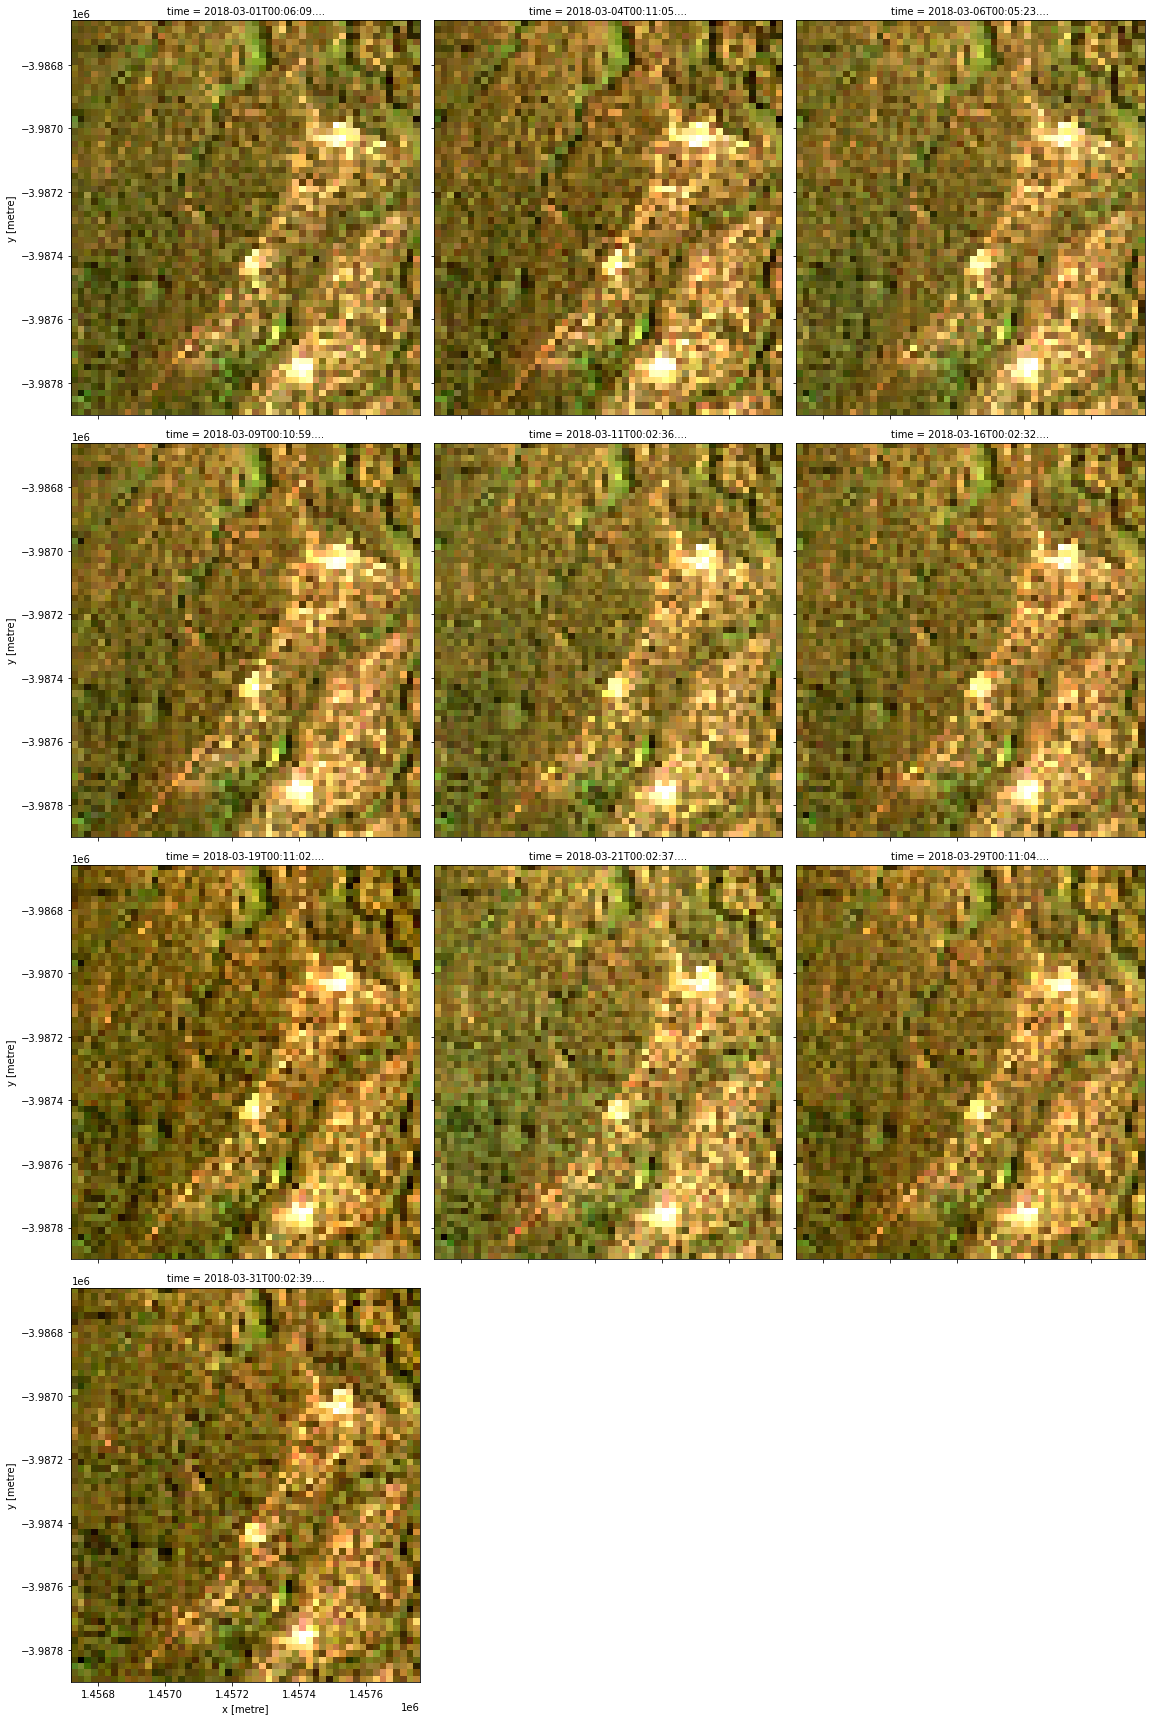

In [8]:
# print a selection of the imagery to check for consistency
timestep = ds.sel(time = '2018-03')
#print(timestep)
rgb(timestep, col = 'time', col_wrap=3) # Modify index dep on images selected above

### Compute TCG over the timeseries

In [9]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=veg_proxy, collection='ga_s2_1')

# Save the NDVI to the dask cluster
ds[veg_proxy] = ds[veg_proxy]

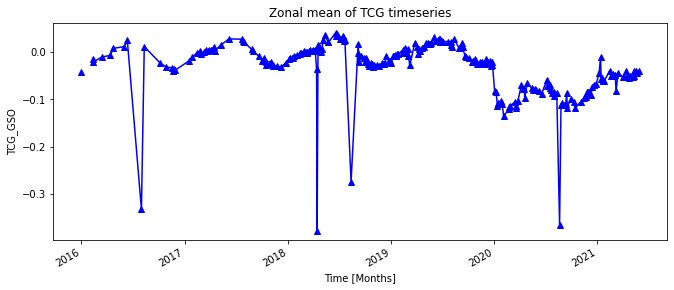

In [10]:
ds[veg_proxy].mean(['x', 'y']).plot.line('b-^', figsize=(11, 4))
plt.title('Zonal mean of TCG timeseries')
plt.xlabel('Time [Months]');

/env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


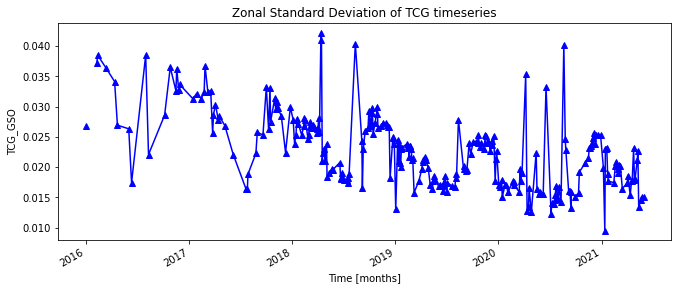

In [11]:
ds[veg_proxy].std(['x', 'y']).plot.line('b-^', figsize=(11, 4))
plt.title('Zonal Standard Deviation of TCG timeseries')
plt.xlabel('Time [months]');

__Smooth the timeseries to remove incoonsistencies__

In [12]:
resample_period='2W'
window=4

veg_smooth=ds[veg_proxy].resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

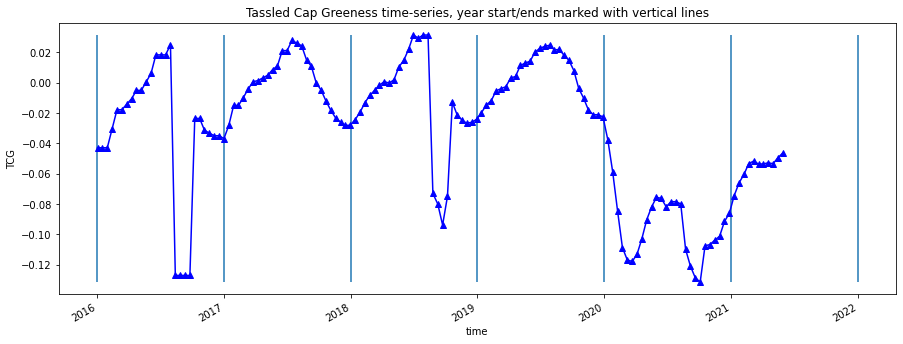

In [13]:
veg_smooth_1D = veg_smooth.mean(['x', 'y'])
veg_smooth_1D.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D.max()
_min=veg_smooth_1D.min()
plt.vlines(np.datetime64('2016-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2022-01-01'), ymin=_min, ymax=_max)
plt.title('Tassled Cap Greeness time-series, year start/ends marked with vertical lines')
plt.ylabel('TCG');

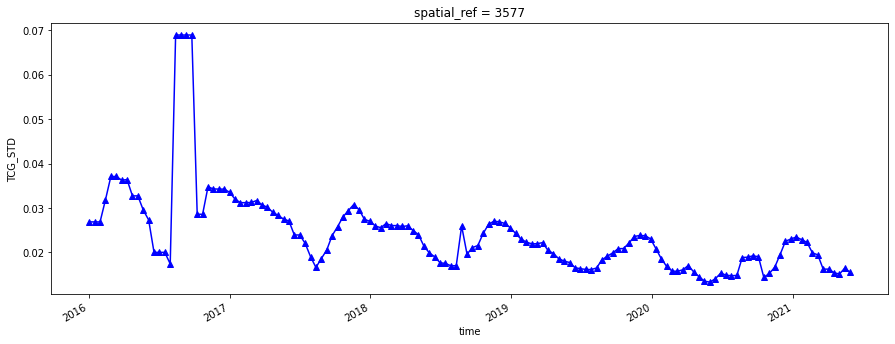

In [14]:
veg_smooth_1D_STD = veg_smooth.std(['x', 'y'])
veg_smooth_1D_STD.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D_STD.max()
_min=veg_smooth_1D_STD.min()
plt.ylabel('TCG_STD');

## Exporting the Data

Modify time for export

In [15]:
veg_smooth_time = veg_smooth.time
arr = np.array(veg_smooth_time, dtype='datetime64[s]')

Exporting Green

In [15]:
df = pd.DataFrame(veg_smooth_1D, columns = ['Green'])

In [16]:
df['time'] = arr

In [17]:
from numpy import savetxt
df.to_csv('Green_smoothed_mean.csv')

In [16]:
df2 = pd.DataFrame(veg_smooth_1D_STD, columns = ['Green_STD'])

In [17]:
df2['time'] = arr

In [18]:
from numpy import savetxt
df2.to_csv('Green_smoothed_std.csv')

### Anomoly investigation
View imagery for selected time periof of September 2020 peak in attempt to determine reason for anomoly

In [16]:
# print a selection of the imagery to check for consistency
timestep1 = ds[veg_proxy].sel(time = '2016-05')
#timestep2 = ds[veg_proxy].sel(time = '2016-06')
#timestep3 = ds[veg_proxy].sel(time = '2016-07')
#print(timestep)
timestep1.plot(cmap = "Greys_r", robust = True, col = 'time', col_wrap=3)
#timestep2.plot(cmap = "Greys_r", robust = True, col = 'time', col_wrap=3)
#timestep3.plot(cmap = "Greys_r", robust = True, col = 'time', col_wrap=3)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 720x0 with 0 Axes>

### Analysis